<a href="https://colab.research.google.com/github/Krithiga-Balakrishnan/RP-24-25J-146/blob/Research-Paper-Recommendation-Krihiga/Scibert_scivocab_Keyword_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import torch

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from google.colab import files

# Prompt to upload a JSON file
uploaded = files.upload()

Saving dataset_Abstract.json to dataset_Abstract.json


In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_df = pd.read_json('dataset_Abstract.json')
data = data_df['Abstract'].tolist()

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Model and tokenizer setup with microsoft/deberta-base
model_checkpoint = "allenai/scibert_scivocab_uncased"  # Update the model name
batch_size = 6
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [ ]:

from datasets import load_dataset

# Update the dataset loading process
dataset = load_dataset("midas/inspec", "extraction")
label_list = np.unique([item for sublist in dataset['train']['doc_bio_tags'] for item in sublist])
label_dict = {label_list[0]: 1, label_list[1]: 2, label_list[2]: 0}

README.md:   0%|          | 0.00/25.4k [00:00<?, ?B/s]

inspec.py:   0%|          | 0.00/6.47k [00:00<?, ?B/s]

extraction/train/0000.parquet:   0%|          | 0.00/390k [00:00<?, ?B/s]

extraction/test/0000.parquet:   0%|          | 0.00/206k [00:00<?, ?B/s]

extraction/validation/0000.parquet:   0%|          | 0.00/201k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
# Tokenize and align labels function
def tokenize_and_align_labels(examples):
    # Add max_length and padding parameters to avoid length issues
    tokenized_inputs = tokenizer(
        examples["document"],
        truncation=True,
        is_split_into_words=True,
        max_length=512,  # Set the maximum length for the model
        padding='max_length'  # Pad to the maximum length
    )

    labels = []
    for i, label in enumerate(examples["doc_bio_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Use -100 for tokens that are not part of any label
            else:
                label_ids.append(label_dict[label[word_idx]])  # Map label to id
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# Map dataset with the updated tokenizer
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
# Set up the scibert model for token classification
torch.manual_seed(0)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list)).to('cuda')
for param in model.parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training arguments update
args = TrainingArguments(
    f"{model_checkpoint.split('/')[-1]}-finetuned-keyword-extraction",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=8e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=8,
    lr_scheduler_type="linear",
    seed=0,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, f1_score

# Compute metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)

    # Flattening the arrays while excluding ignored labels (-100)
    true_predictions = [p for prediction, label in zip(predictions, labels) for (p, l) in zip(prediction, label) if l != -100]
    true_labels = [l for prediction, label in zip(predictions, labels) for (p, l) in zip(prediction, label) if l != -100]

    # Compute metrics with macro averaging for F1, precision, and recall
    precision, recall, f1, _ = precision_recall_fscore_support(y_true=true_labels, y_pred=true_predictions, average='macro')
    f1_macro = f1_score(y_true=true_labels, y_pred=true_predictions, average='macro')

    return {
        'eval/precision': precision,
        'eval/recall': recall,
        'eval/f1': f1,
        'eval/f1_macro': f1_macro,
    }


In [ ]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


<ipython-input-14-6f88ff71208e>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Training
training_output = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Eval/precision,Eval/recall,Eval/f1,Eval/f1 Macro
1,0.302800,0.219765,0.728586,0.645505,0.679815,0.679815
2,0.200400,0.204498,0.721541,0.747666,0.733531,0.733531
3,0.177900,0.200271,0.729535,0.754460,0.741528,0.741528
4,0.162800,0.203133,0.724853,0.775232,0.747894,0.747894
5,0.148300,0.205993,0.728652,0.767865,0.747055,0.747055
6,0.140200,0.209871,0.727651,0.767902,0.746338,0.746338
7,0.131200,0.215300,0.726132,0.773235,0.747987,0.747987
8,0.126000,0.216280,0.727921,0.764700,0.745245,0.745245


In [ ]:
torch.cuda.empty_cache()

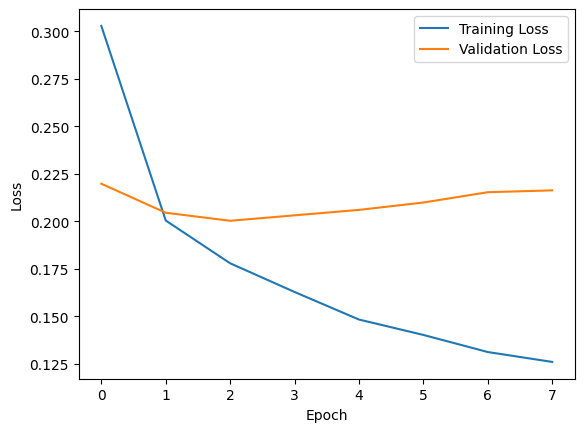

In [ ]:
# Plotting losses and F1 scores for tracking
loss = [d["loss"] for d in trainer.state.log_history if "loss" in d]
val_loss = [d["eval_loss"] for d in trainer.state.log_history if "eval_loss" in d]
plt.plot(loss)
plt.plot(val_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Evaluation on the test set
test_output = trainer.evaluate(tokenized_dataset["test"])
print(f"Evaluation on test set:\n Loss: {test_output['eval_loss']:.4f}\n Precision: {test_output['eval_eval/precision']:.4f}\n Recall: {test_output['eval_eval/recall']:.4f}\n F1: {test_output['eval_eval/f1']:.4f}\n F1 - Macro: {test_output['eval_eval/f1_macro']:.4f}")


Evaluation on test set:
 Loss: 0.2107
 Precision: 0.7483
 Recall: 0.7691
 F1: 0.7583
 F1 - Macro: 0.7583


In [ ]:
def extract_keywords_model(data, batch_size=2):
    fine_tuned_keywords = []  # Store fine-tuned keywords

    for idx in tqdm(range(0, len(data), batch_size)):
        # Prepare inputs for the model
        inputs = tokenizer(data[idx: idx + batch_size], return_tensors='pt', padding=True, truncation=True).to('cuda')

        # Get model predictions for keyword extraction
        outputs = model(**inputs)
        predictions = torch.softmax(outputs.logits, dim=-1).argmax(-1)

        for idx_item in range(predictions.shape[0]):
            # Extract fine-tuned keywords based on token classification
            indices_single = []
            keywords_item = []

            for idx, label in enumerate(predictions[idx_item].tolist()):
                if label == 1:  # Label for start of keyword
                    indices_single.append(idx)
                elif label == 2 and len(indices_single) > 0:
                    indices_single.append(idx)
                elif label == 0 and len(indices_single) > 0:
                    # End of a keyword sequence, decode and add to list
                    keywords_item.append(tokenizer.decode(inputs.input_ids[idx_item][indices_single]).strip())
                    indices_single = []  # Reset for the next sequence

            # Append the fine-tuned keywords for this abstract
            fine_tuned_keywords.append(keywords_item)

            # NER integration has been commented out
            # ner_results = ner_pipeline(data[idx + idx_item])  # Get NER results for current abstract
            # ner_keywords = [result['word'] for result in ner_results if result['entity_group'] in ['ORG', 'LABEL_1', 'LABEL_2', 'MISC']]
            # ner_keywords_all.append(list(set(ner_keywords)))  # Avoid duplicates and store NER results

    return fine_tuned_keywords

# Extract fine-tuned keywords for each abstract in the dataset
fine_tuned_keywords = extract_keywords_model(data, batch_size=2)

# Update the DataFrame with only the fine-tuned keywords
data_df['fine-tuned'] = fine_tuned_keywords

# Display the first few rows of the DataFrame to verify
print(data_df[['Abstract', 'fine-tuned']].head())

# Save as JSON file, without ner_keywords column
data_df[['Abstract', 'fine-tuned']].to_json("fine_tuned_keywords.json", orient="records", lines=True)


  0%|          | 0/26 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


                                            Abstract  \
0  Over the last several years, fraudulent credit...   
1  Support Vector Machine (SVM) is a classificati...   
2  As most industries demand smart analytics to k...   
3  The dataset is the collection of three differe...   
4  Due to scarcity of natural resources and degra...   

                                          fine-tuned  
0  [##ulent credit card transactions, financial i...  
1  [support vector machine, svm, classification, ...  
2  [smart analytics, machine learning, deep learn...  
3  [comparison matrix, machine learning, big data...  
4  [natural resources, land quality, natural reso...  


In [ ]:
# Keyword extraction function
def extract_keywords_model(data, batch_size=2):
    keywords = []
    for idx in tqdm(range(0, len(data), batch_size)):
        inputs = tokenizer(data[idx: idx + batch_size], return_tensors='pt', padding=True, truncation=True).to('cuda')
        outputs = model(**inputs)
        predictions = torch.softmax(outputs.logits, dim=-1).argmax(-1)
        for idx_item in range(predictions.shape[0]):
            indices_item = []
            indices_single = []
            keywords_item = []
            for idx, label in enumerate(predictions[idx_item].tolist()):
                if label == 1:
                    indices_single.append(idx)
                elif label == 2 and len(indices_single) > 0:
                    indices_single.append(idx)
                elif label == 0 and len(indices_single) > 0:
                    indices_item.append(indices_single)
                    keywords_item.append(tokenizer.decode(inputs.input_ids[idx_item][indices_single]).strip())
                    indices_single = []
            keywords.append(keywords_item)
    return keywords

In [ ]:
# Extract keywords for each abstract in the dataset
model_keywords = extract_keywords_model(data, batch_size=2)
data_df['fine-tuned'] = pd.DataFrame([', '.join(keywords) for keywords in model_keywords])
data_df.head()

  0%|          | 0/26 [00:00<?, ?it/s]

,paper_id,title,authors,year,journal,doi,Abstract,keywords,fine-tuned
0,Paper_001,Detection of Credit Card Fraudulent Transactio...,"[Asifuddin Nasiruddin Ahmed, Ravinder Saini]",2023,Iternational Conference for Innovation in Tech...,10.1109/INOCON57975.2023.10101137,"Over the last several years, fraudulent credit...","[Fraud Detection, AI, Machine Learning Algorit...","##ulent credit card transactions, financial in..."
1,Paper_002,A HSC-BASED SAMPLE SELECTION METHOD FOR SUPPOR...,"[Qing He, Ning Li, Zhong-Zhi Shi]",2010,Ninth International Conference on Machine Lear...,10.1109/ICMLC.2010.5580974,Support Vector Machine (SVM) is a classificati...,"[Support vector machines, Sample selection, Hy...","support vector machine, svm, classification, m..."
2,Paper_003,A Learning Transition from Machine Learning to...,"[Mercy Dol, Angelina Geetha]",2021,International Conference on Emerging Technique...,10.1109/ICETCI51973.2021.9574066,As most industries demand smart analytics to k...,"[Machine Learning, Deep Learning, Auto ML, Mac...","smart analytics, machine learning, deep learni..."
3,Paper_004,A Comparative Analysis of Big Data Technologie...,"[Sandeep Kour, Sritha Zeth Dey Babu]",2021,10th International Conference on System Modeli...,10.1109/SMART52563.2021.9676291,The dataset is the collection of three differe...,"[Big Data, Machine learning, SVM, Information,...","comparison matrix, machine learning, big data ..."
4,Paper_005,A Comparative Analysis of Supervised Machine L...,"[ Krupa Patel, Hiren B. Patel]",2021,"Fourth International Conference on Electrical,...",10.1109/ICECCT52121.2021.9616731,Due to scarcity of natural resources and degra...,"[Agriculture, Machine Learning, supervised, un...","natural resources, land quality, natural resou..."


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=data_df)

https://docs.google.com/spreadsheets/d/1F3ZY1A9gb60kEr26ie6HN_Ml5NEzQk6d3a8cQxXz094#gid=0


In [ ]:
from transformers import Trainer

# Save model to a specified directory
output_dir = "/content/drive/MyDrive/Research_Model/suggestionKeywords_V2"  # specify your Google Drive path
trainer.save_model(output_dir)  # Saves model, config, and tokenizer